# Connect python and SQL

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from lime.lime_tabular import LimeTabularExplainer
import pandas as pd
import numpy as np

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV

from lime.lime_tabular import LimeTabularExplainer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option('display.max_columns', None)

In [14]:
# Class to help select categorical vs. continuous data as part of the pipeline (see below)
class DataSelector(BaseEstimator, TransformerMixin):
    '''Select columns of numpy arrays based on attribute_indices.'''

    def __init__(self, attribute_indices):
        self.attribute_indices = attribute_indices

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array(X)[:,self.attribute_indices]

In [15]:
# Load data with header names

df = pd.read_csv('/Users/tarabaris/Insight_Data_Science/project/perm_visa_all_years_C_D_limes.csv')

# Order features (numeric first, categorical second) since it's convenient later
feature_order = ['salary',
                 'state',
                 'job_title',
                 'level',
                 'education',
                 'citizenship',
                 'admission',
                 'ownership',
                 'language',
                 'outcome']


data = df[feature_order]



In [16]:
data.head()

,salary,state,job_title,level,education,citizenship,admission,ownership,language,outcome
0,83366.0,WI,Industrial_Engineers,Level IV,Bachelor's,INDIA,H-1B,N,N,0.0
1,16973.0,MS,Meat_Poultry_and_Fish_Cutters_and_Trimmers,Level I,None,SOUTH KOREA,NaN,N,N,1.0
2,49982.0,CO,Biological_Scientists_All_Other,Level I,Doctorate,GERMANY,H-1B,N,N,1.0
3,43514.0,WA,Market_Research_Analysts_and_Marketing_Special...,Level I,Master's,SOUTH KOREA,E-2,N,N,0.0
4,16973.0,MS,Meat_Poultry_and_Fish_Cutters_and_Trimmers,Level I,None,SOUTH KOREA,NaN,N,N,1.0


In [17]:
data.shape

(230233, 10)

In [18]:
data.dtypes

salary         float64
state           object
job_title       object
level           object
education       object
citizenship     object
admission       object
ownership       object
language        object
outcome        float64
dtype: object

In [19]:
#We want to replace any infinity values with "nan" so that we can drop them along with any other "nan" in order to run 
#throught our model
data.replace([np.inf, -np.inf], np.nan)

,salary,state,job_title,level,education,citizenship,admission,ownership,language,outcome
0,83366.0,WI,Industrial_Engineers,Level IV,Bachelor's,INDIA,H-1B,N,N,0.0
1,16973.0,MS,Meat_Poultry_and_Fish_Cutters_and_Trimmers,Level I,None,SOUTH KOREA,NaN,N,N,1.0
2,49982.0,CO,Biological_Scientists_All_Other,Level I,Doctorate,GERMANY,H-1B,N,N,1.0
3,43514.0,WA,Market_Research_Analysts_and_Marketing_Special...,Level I,Master's,SOUTH KOREA,E-2,N,N,0.0
4,16973.0,MS,Meat_Poultry_and_Fish_Cutters_and_Trimmers,Level I,None,SOUTH KOREA,NaN,N,N,1.0
5,24710.0,MI,Cooks_Restaurant,Level IV,None,SOUTH KOREA,F-1,N,N,0.0
6,55682.0,NY,Public_Relations_Specialists,Level II,Bachelor's,CANADA,H-1B,N,N,0.0
7,16973.0,MS,Meat_Poultry_and_Fish_Cutters_and_Trimmers,Level I,None,SOUTH KOREA,NaN,N,N,1.0
8,16973.0,MS,Meat_Poultry_and_Fish_Cutters_and_Trimmers,Level I,None,SOUTH KOREA,NaN,N,N,1.0
9,16973.0,MS,Meat_Poultry_and_Fish_Cutters_and_Trimmers,Level I,None,SOUTH KOREA,NaN,N,N,1.0


In [20]:
#Here we drop 'nan', which in this case also includes the converte infiinity values
data = data.dropna()

In [21]:
data.columns

Index([u'salary', u'state', u'job_title', u'level', u'education',
       u'citizenship', u'admission', u'ownership', u'language', u'outcome'],
      dtype='object')

In [22]:
data.shape

(200412, 10)

In [23]:
# Define categorical names and indices
categorical_features = list(data.columns[1:])
categorical_idx = list(range(1, len(data.columns)-1))
continuous_features = list(data.columns[0:1])
continuous_idx = list(range(0,1))

Y = data.outcome.values
X = data.drop("outcome", axis=1).values

# Get feature names and their values for categorical data (needed for LIME)
categorical_names = {}
for idx, feature in zip(categorical_idx, categorical_features):
    le = LabelEncoder()
    X[:, idx] = le.fit_transform(X[:, idx])
    categorical_names[idx] = le.classes_

# To suppress a warning later (not strictly necessary)
X = X.astype(float)

# Train test split
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, train_size=0.70, random_state=42
)

# Now the True class (1) is actually the "denied" class because it's the minority class and I want to tune 
#the model to optimize this class

In [24]:
#In order to oversample, I separate out the data by the class, 1 is "True"/"Denied", and 0 is "False"/"Certified"
X_true = x_train[y_train == 1]
X_false = x_train[y_train == 0]

In [25]:
X_true.shape

(6608, 9)

In [26]:
X_false.shape

(133680, 9)

In [38]:
#I specify that I want the True class size to match the False class size when I oversample
over_sample_size = 133680
X_true_sample = X_true[np.random.choice(len(X_true), size=133680, replace=True)]
Y_true_sample = [1] * over_sample_size
X_train_combined = np.concatenate([X_true_sample, X_false])
Y_train_combined = np.array(Y_true_sample + [0] * len(X_false))





In [39]:
Y_train_combined.shape

(267360,)

In [40]:
X_train_combined.shape

(267360, 9)

# Let's run a grid search and cross-validation to tune the hyperparameters

In [19]:
param_grid = {'n_estimators': [200, 500, 1000],
               'min_samples_split': [8, 12, 16, 20],
               'max_depth': [25, 50, 75, 150]}


#scoring=f1 to tune for better precision and recall


rf = RandomForestClassifier()
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train_combined, Y_train_combined)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 10.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [200, 500, 1000], 'min_samples_split': [8, 12, 16, 20], 'max_depth': [25, 50, 75, 150]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=1)

In [21]:
pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_min_samples_split,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
26,30.255822,1.501242,0.962989,0.970879,75,8,1000,"{u'min_samples_split': 8, u'n_estimators': 100...",1,0.965711,0.970645,0.960134,0.971598,0.963156,0.970697,0.962398,0.970967,0.963545,0.970487,0.108901,0.014045,0.001803,0.000391
2,28.866251,1.413987,0.962938,0.970759,25,8,1000,"{u'min_samples_split': 8, u'n_estimators': 100...",2,0.965297,0.970538,0.959032,0.971528,0.963572,0.970433,0.962756,0.970967,0.964031,0.970327,0.503506,0.031886,0.002119,0.000442
24,5.989634,0.297350,0.962847,0.970845,75,8,200,"{u'min_samples_split': 8, u'n_estimators': 200...",3,0.965530,0.970599,0.959286,0.971643,0.964399,0.970610,0.961682,0.970967,0.963337,0.970406,0.048533,0.004837,0.002186,0.000438
38,26.929272,1.346181,0.962818,0.970875,150,8,1000,"{u'min_samples_split': 8, u'n_estimators': 100...",4,0.965323,0.970609,0.960179,0.971643,0.962922,0.970624,0.962440,0.971034,0.963226,0.970464,0.068327,0.022032,0.001647,0.000428
37,13.489255,0.667135,0.962791,0.970833,150,8,500,"{u'min_samples_split': 8, u'n_estimators': 500...",5,0.965323,0.970609,0.959821,0.971643,0.963765,0.970552,0.962218,0.970967,0.962825,0.970396,0.049863,0.022558,0.001817,0.000446
25,15.124398,0.735052,0.962769,0.970853,75,8,500,"{u'min_samples_split': 8, u'n_estimators': 500...",6,0.965504,0.970563,0.959241,0.971598,0.963156,0.970697,0.962218,0.970967,0.963725,0.970442,0.051301,0.003175,0.002064,0.000411
36,6.007529,0.280295,0.962747,0.970849,150,8,200,"{u'min_samples_split': 8, u'n_estimators': 200...",7,0.965530,0.970645,0.959108,0.971597,0.964040,0.970610,0.961903,0.970989,0.963157,0.970406,0.383561,0.019251,0.002170,0.000418
13,17.421421,0.851579,0.962722,0.970812,50,8,500,"{u'min_samples_split': 8, u'n_estimators': 500...",8,0.965142,0.970563,0.959062,0.971552,0.964179,0.970580,0.961860,0.970967,0.963364,0.970396,0.332157,0.102744,0.002123,0.000415
14,32.851500,1.516697,0.962719,0.970840,50,8,1000,"{u'min_samples_split': 8, u'n_estimators': 100...",9,0.965504,0.970609,0.959598,0.971598,0.963267,0.970583,0.962039,0.970967,0.963184,0.970442,0.415832,0.066170,0.001922,0.000417
1,14.210063,0.630345,0.962688,0.970773,25,8,500,"{u'min_samples_split': 8, u'n_estimators': 500...",10,0.965116,0.970493,0.958853,0.971528,0.963226,0.970552,0.962577,0.970967,0.963670,0.970327,0.477991,0.007046,0.002091,0.000432


# Now we can run the random forest model with the highest ranked hyperparameters

In [41]:
model = RandomForestClassifier(n_estimators=1000, max_depth = 75, min_samples_split = 8, n_jobs=-1, class_weight='balanced')
model.fit(X_train_combined, Y_train_combined)
pred = model.predict(x_test)
proba = model.predict_proba(x_test)





In [42]:
model.score(x_test, y_test)

0.90454726897744664

In [60]:
y_predicted = model.predict(x_test)
y_true = y_test

In [61]:
#This will print the precision and recall for both classes
print classification_report(y_true, y_predicted)

             precision    recall  f1-score   support

        0.0       0.96      0.94      0.95     57210
        1.0       0.19      0.29      0.23      2914

avg / total       0.92      0.90      0.91     60124



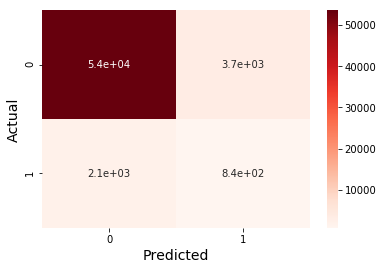

In [85]:
cm = confusion_matrix(y_true, y_predicted)
sns.heatmap(cm, annot=True, cmap="Reds")
plt.xlabel("Predicted", size=14)
plt.ylabel("Actual", size=14)

plt.show()

# I want to know which features are most important

In [45]:
importances = model.feature_importances_
#std = np.std([tree.feature_importances_ for tree in best_estimator.estimators_],
#             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
feature_names = data.columns[:-1]
for f in range(data.shape[1]-1):
    print("%2d. feature %s (%f)" %
          (f + 1, feature_names[f], importances[indices[f]]))

Feature ranking:
 1. feature salary (0.407086)
 2. feature state (0.155311)
 3. feature job_title (0.145668)
 4. feature level (0.112300)
 5. feature education (0.064913)
 6. feature citizenship (0.056833)
 7. feature admission (0.046644)
 8. feature ownership (0.007514)
 9. feature language (0.003730)


In [46]:
ranking_df = pd.DataFrame([(feature_names[f], importances[indices[f]]) for f in range(data.shape[1]-1)])
ranking_df.columns = ["feature_name", "importance"]
ranking_df

,feature_name,importance
0,salary,0.407086
1,state,0.155311
2,job_title,0.145668
3,level,0.112300
4,education,0.064913
5,citizenship,0.056833
6,admission,0.046644
7,ownership,0.007514
8,language,0.003730


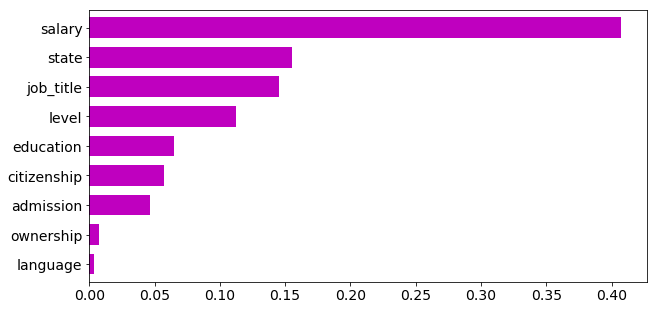

In [47]:
ranking_df.plot(kind="barh", color ='m',figsize=(10,5), fontsize=(14), width = .7, stacked=True, grid=False, legend=False)
plt.gca().set_yticklabels(ranking_df.feature_name)
plt.gca().invert_yaxis()

# Let's look at logistic regression and see how it performs in comparison

# We can check which type of penalty is best for the logistic regression model

In [48]:
param_grid = {'penalty': ['l1', 'l2'],}


lr = LogisticRegression()
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train_combined, Y_train_combined)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.8s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.1s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2']}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='f1', verbose=1)

In [50]:
pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_penalty,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,3.056470,0.036185,0.585849,0.585808,l1,{u'penalty': u'l1'},1,0.589446,0.584027,0.589436,0.585678,0.584755,0.586775,0.583453,0.586357,0.582158,0.586203,0.089110,0.011981,0.003045,0.000957
1,2.689246,0.020790,0.571684,0.571888,l2,{u'penalty': u'l2'},2,0.578915,0.575850,0.577216,0.573434,0.573631,0.576047,0.572061,0.574516,0.556599,0.559593,0.839897,0.004794,0.007929,0.006220


# Let's now use 'l1' as our penalty in the lr model

In [51]:
lr = LogisticRegression(penalty='l1')
lr.fit(X_train_combined, Y_train_combined)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [52]:
##accuratcy is not as good
lr.score(x_test, y_test)

0.63357394717583659

In [62]:
y_predicted_lr = lr.predict(x_test)
y_true_lr = y_test

In [86]:
print classification_report(y_true, y_predicted_lr)

             precision    recall  f1-score   support

        0.0       0.97      0.64      0.77     57210
        1.0       0.07      0.56      0.13      2914

avg / total       0.92      0.63      0.74     60124



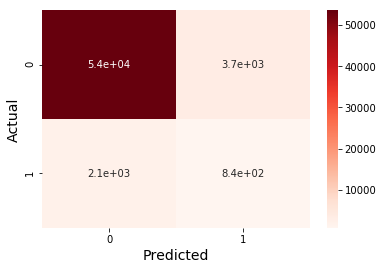

In [87]:
cm = confusion_matrix(y_true, y_predicted)
sns.heatmap(cm, annot=True, cmap="Reds")
plt.xlabel("Predicted", size=14)
plt.ylabel("Actual", size=14)

plt.show()

# We can plot ROC curves for our different models

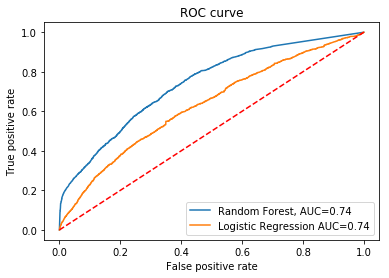

In [81]:
y_pred_rf = model.predict_proba(x_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

y_pred_lr = lr.predict_proba(x_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)

roc_auc=auc(fpr_rf, tpr_rf)
#plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf, tpr_rf, label='Random Forest, AUC=%0.2f'% roc_auc)
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression AUC=%0.2f'% roc_auc)

#roc_auc=auc(fpr_rf, tpr_rf)
#plt.plot(fpr_rf, tpr_rf, label='RF')
#plt.plot(fpr_lr,tpr_lr, label='LR')
#plt.plot(fpr_rf, tpr_rf, label='AUC=%0.2f'% roc_auc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.plot([0,1],[0,1],'r--')
#roc_auc=auc(fpr_rf, tpr_rf)
plt.show()




# Now we can use LIME to explain why an indiviual was either certified or denied

In [49]:
# Use LIME to explain individual predictions, initialize explainer object
explainer = LimeTabularExplainer(
    X_train_combined[:, :-1],
    class_names=['Denied', 'Certified'],
    feature_names=list(data.columns[:-1]),
    categorical_features=categorical_idx,
    categorical_names=categorical_names,
    discretize_continuous=True
)

('Probability of receiving a visa:', 0.65000000000000002)


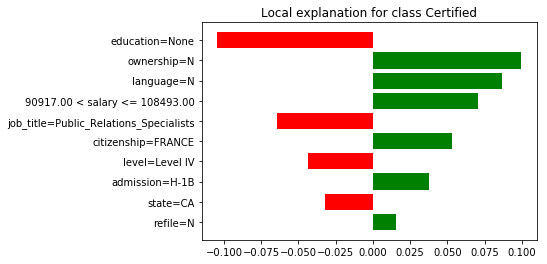

In [203]:
# Explain a prediction ("local interpretability"): 
# Now we see that the pipeline that takes raw data and returns the prediction of the trained model now comes in conveniently.
example = 3
exp = explainer.explain_instance(test[:, :-1][example], my_model.predict_proba, num_features=10)


# exp = explainer.explain_instance(test[example], model.predict_proba, num_features=5)
print('Probability of receiving a visa:', exp.predict_proba[1])
exp.as_pyplot_figure()

('Probability of receiving a visa:', 0.78988095238095235)


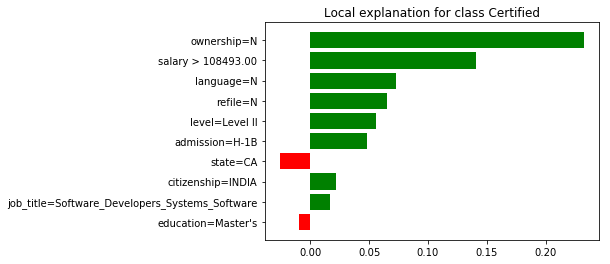

In [213]:
example = 10
exp = explainer.explain_instance(test[:, :-1][example], my_model.predict_proba, num_features=10)


# exp = explainer.explain_instance(test[example], model.predict_proba, num_features=5)
print('Probability of receiving a visa:', exp.predict_proba[1])
exp.as_pyplot_figure()

('Probability of receiving a visa:', 0.5)


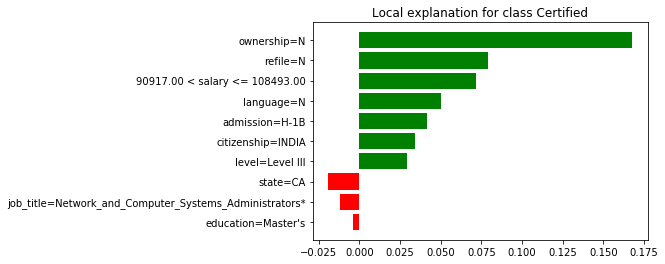

In [219]:
example = 608
exp = explainer.explain_instance(test[:, :-1][example], my_model.predict_proba, num_features=10)


# exp = explainer.explain_instance(test[example], model.predict_proba, num_features=5)
print('Probability of receiving a visa:', exp.predict_proba[1])
exp.as_pyplot_figure()

# Let's make some plots!